# Are there any genres that perform better in foreign markets?

In [1]:
from moviesdb import moviesdb as mdb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data
Below we load the database and print a list of tables.

In [2]:
db = mdb.MoviesDb()
for table in db.list_tables():
    print(table)

titles
runtimes
genres
ratings
budgets
names
principals


We will be primarily concerned with data in the `budgets` table and the `genres` table. Below we print a list of columns for each table.

In [3]:
print(f'=== budgets ===')
for column in db.list_column_names('budgets'):
    print(column)
print('')
print(f'=== genres ===')
for column in db.list_column_names('genres'):
    print(column)

=== budgets ===
id
primary_title
start_year
release_date
production_budget
domestic_gross
worldwide_gross

=== genres ===
tconst
Action
Adult
Adventure
Animation
Biography
Comedy
Crime
Documentary
Drama
Family
Fantasy
Game_Show
History
Horror
Music
Musical
Mystery
News
Reality_TV
Romance
Sci_Fi
Short
Sport
Talk_Show
Thriller
War
Western


We note that `worldwide gross` column includes the gross income from the `domestic_gross` column. Below we will compute what proportion of `worldwide_gross` comes from `domestic_gross`. This has the added benefit of producing a unit-less measure that is insensitive to inflation. 

In order to properly join the `budgets` table with the `genres` table, we will need to join on the `titles` table which contains all of the variables `tconst`, `primary_title`, and `start_year`. We execute the necessary query and load it as a data frame below.

In [4]:
query = """
SELECT b.primary_title, b.start_year, b.production_budget, b.domestic_gross, b.worldwide_gross, g.*
FROM budgets AS b
JOIN titles as t 
USING(primary_title, start_year)
JOIN genres AS g
USING(tconst);
"""
df = db.load_query_as_df(query)

Because we have joined starting with the `budgets` table, we will only return films where budget data is available. 

## Question specific data cleaning
We note that if `worldwide_gross` is zero, then the proportion that we wish to inspect will be undefined. For this reason, we drop rows where `worldwide_gross` is zero. 

In [5]:
df = df[df['worldwide_gross'] > 0]

Additionally, we are not interested in genres that are not represented in the data. We drop columns with all false values below.

In [6]:
df = df.loc[:,df.any(axis = 0)]

## Computations

Next we compute the proportion of `worldwide_gross` that comes from `domestic_gross`. We name this variable `domestic_proportion`.

In [7]:
df['domestic_proportion'] = df['domestic_gross'] / df['worldwide_gross']

We note that genres are not mutually exclusive. We will compute the mean `domestic_proportion` for each genre realizing that films with multiple genres will contribute to multiple means. To start the computation, we need a list of genres that are represented in our data. 

In [8]:
full_genre_list = db.list_column_names('genres')[1:]
genre_list = list(set(df.columns).intersection(set(full_genre_list)))

In [9]:
mean_proportions_list = []
for genre in genre_list:
    df_genre = df.query(f'{genre} == 1')
    proportion_dict = {
        'genre': genre,
        'mean_proportion': df_genre['domestic_proportion'].mean()
    }
    mean_proportions_list.append(proportion_dict)
    
df_proportions = pd.DataFrame.from_dict(mean_proportions_list).sort_values(by='mean_proportion') 

# Make visualization

[Text(0.5, 0, 'Domestic Proportion'),
 Text(0, 0.5, 'Genre'),
 Text(0.5, 1.0, 'Domestic as Proportion of Worldwide Gross Revenue by Genre')]

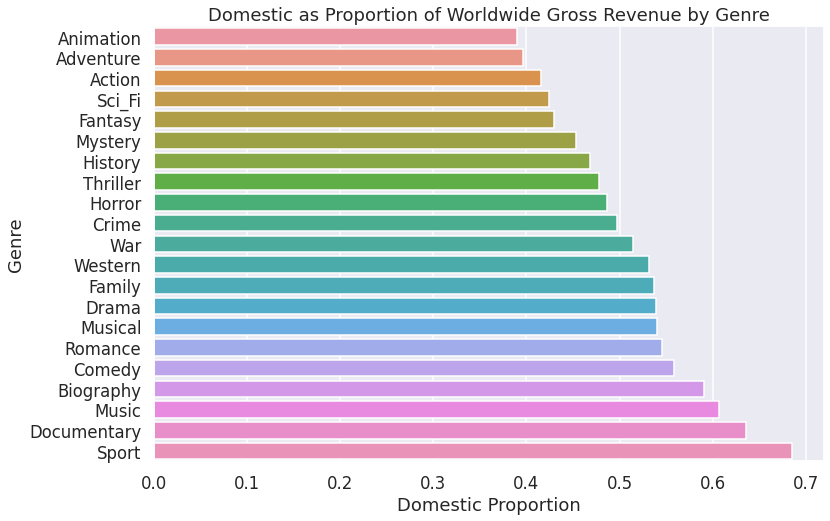

In [10]:
fig = plt.figure(figsize=(12,8))
sns.set_context('talk')
sns.set_style('darkgrid')
ax = sns.barplot(y='genre', x='mean_proportion', data=df_proportions, orient="h")
ax.set(xlabel = 'Domestic Proportion', 
       ylabel = 'Genre',
       title = 'Domestic as Proportion of Worldwide Gross Revenue by Genre'
      )

In [17]:
fig.savefig('../images/domestic_proportion.png', bbox_inches='tight')